In [ ]:
#Veriler çekildi ve books3.csv dosyasına kaydedildi

import requests
from bs4 import BeautifulSoup
import csv
import time

headers = {
    "User-Agent": "Mozilla/5.0 (Windows NT 10.0; Win64; x64) "
                  "AppleWebKit/537.36 (KHTML, like Gecko) "
                  "Chrome/122.0.0.0 Safari/537.36"
}

base_url = "https://www.dr.com.tr/kategori/Kitap/Edebiyat/Roman/grupno=00211?ShowNotForSale=True&Page={}"
detail_base_url = "https://www.dr.com.tr"

kitaplar = []

for page in range(1, 13):  
    print(f"\n {page}. sayfa işleniyor...")
    url = base_url.format(page)
    response = requests.get(url, headers=headers)
    soup = BeautifulSoup(response.text, 'html.parser')

    kitap_linkleri = soup.find_all("a", href=True)
    kitap_url_list = []

    for link in kitap_linkleri:
        href = link['href']
        if href.startswith("/kitap/") and "urunno" in href:
            full_url = detail_base_url + href
            if full_url not in kitap_url_list:
                kitap_url_list.append(full_url)

    print(f" {len(kitap_url_list)} kitap bulundu.")

    for kitap_url in kitap_url_list:
        try:
            r = requests.get(kitap_url, headers=headers)
            soup = BeautifulSoup(r.text, 'html.parser')

            # Açıklama
            detail_div = soup.find("div", class_="js-detail-product")
            aciklama = detail_div.get_text(separator=" ", strip=True) if detail_div else "Yok"

            kitap_adi = yazar = isbn = ""

            # Kitap bilgileri
            prd_props = soup.select("div.product-property ul.js-list-prd-property li")
            for li in prd_props:
                label = li.find("strong")
                value = li.find("span")
                if label and value:
                    label_text = label.get_text(strip=True)
                    value_text = value.get_text(strip=True)
                    if "Kitap Adı" in label_text:
                        kitap_adi = value_text
                    elif "Yazar" in label_text:
                        yazar = value_text
                    elif "Barkod" in label_text:
                        isbn = value_text.strip()

            kitap = {
                "Kitap Adı": kitap_adi,
                "Yazar": yazar,
                "ISBN": isbn,
                "Açıklama": aciklama
            }

            kitaplar.append(kitap)

            #  Ekrana yazdır
            print("\n Kitap Adı:", kitap_adi)
            print(" Yazar:", yazar)
            print(" ISBN:", isbn)
            print(" Açıklama:", aciklama[:100], "...")  
            print("-" * 10)

            time.sleep(0.5)

        except Exception as e:
            print(f" Hata oluştu: {e}")
            continue

# CSV'ye kaydet
with open("books3.csv", "w", newline="", encoding="utf-8-sig") as file:
    writer = csv.DictWriter(
        file,
        fieldnames=["Kitap Adı", "Yazar", "ISBN", "Açıklama"],
        quoting=csv.QUOTE_ALL  # tüm hücreleri " " içine al
    )
    writer.writeheader()
    writer.writerows(kitaplar)

print("\n Tüm kitaplar başarıyla çekildi ve 'books3.csv' dosyasına kaydedildi.")



📄 1. sayfa işleniyor...
🔗 40 kitap bulundu.

 Kitap Adı: Sırların Sırrı
 Yazar: Dan Brown
 ISBN: 9789752130678
 Açıklama: “GELECEK, GEÇMİŞİ ETKİLEYEBİLİR Mİ?" Gerilim romanlarının tartışmasız ismi Dan Brown uzun süre sonra ...
----------

 Kitap Adı: Gölgelerin Kralı - Güneşsiz Cilt 2
 Yazar: Jean-Christophe Grange
 ISBN: 9786255683199
 Açıklama: Bir katil, başka bir katili saklayabilir... Çözülmüş bir vakanın gölgesinde, hâlâ bir kor yanmaya de ...
----------

 Kitap Adı: Bekle Beni
 Yazar: Zülfü Livaneli
 ISBN: 9789750766091
 Açıklama: Polisler Selim’i alıp götürdüler. Gitmeden önce Leyla’ya son bir kez sarıldı, kulağına fısıldadı: “G ...
----------

 Kitap Adı: Cehennem Diskosu - Güneşsiz Cilt 1
 Yazar: Jean-Christophe Grange
 ISBN: 9786255683038
 Açıklama: 1980’ler, Paris: Diskolar, dans pistleri dolu. Diğer yandan ne olduğu anlaşılmayan bir hastalık kol  ...
----------

 Kitap Adı: Cemil Reloaded
 Yazar: Reha Çamuroğlu
 ISBN: 9786051417035
 Açıklama: Her şeyi gördük mü, gördüğümü

In [ ]:
#veriler locale kurulan deepseek modeli ile özetlendi ve books3_özetli.xlsx dosyasına kaydedildi

import pandas as pd
import requests
import json

# Excel dosyasını oku
dosya_yolu = "C:\\Users\\Tuğba\\Desktop\\tezYapim\\books3.xlsx"
data = pd.read_excel(dosya_yolu)

# DeepSeek model API ayarları
API_URL = "http://127.0.0.1:1234/v1/chat/completions"
MODEL_NAME = "deepseek/deepseek-r1-0528-qwen3-8b"

ozetler = []

for aciklama in data["Açıklama"]:
    if pd.isna(aciklama) or len(aciklama.strip()) == 0:
        ozetler.append("")
        continue

    payload = {
        "model": MODEL_NAME,
        "messages": [
            {
                "role": "system",
                "content": (
                    "You are a text summarization model. Only produce a short, clear, meaningful summary in Turkish in 3-5 sentences. "
                    "Do not include internal thoughts, explanations, analyses, or any ‘think’ sections. "
                    "Only output the summary text."
                )
            },
            {"role": "user", "content": aciklama}
        ],
        "temperature": 0.0,
        "stream": False
    }

    try:
        response = requests.post(API_URL, json=payload, headers={"Content-Type": "application/json"})
        result = response.json()

        if "choices" in result and len(result["choices"]) > 0:
            raw_summary = result["choices"][0]["message"]["content"]

            if "<think>" in raw_summary:
                parts = raw_summary.split("</think>")
                summary = parts[-1].strip()
            else:
                summary = raw_summary.strip()

            ozetler.append(summary)
        else:
            ozetler.append("")

    except:
        ozetler.append("")

# Yeni sütun olarak ekle ve Excel’e kaydet
data["Özet"] = ozetler
output_path = "C:\\Users\\Tuğba\\Desktop\\tezYapim\\books3_özetli.xlsx"
data.to_excel(output_path, index=False)


In [ ]:
#özetli veriler json formatına dönüştürüldü ve books.json dosyasına kaydedildi

import pandas as pd
import json

# Excel dosyasını oku
df = pd.read_excel(r"C:\\Users\\Tuğba\\Desktop\\tezYapim\\books3_özetli.xlsx")  

# JSON'a dönüştür
json_data = df.to_dict(orient="records")

# JSON dosyası olarak kaydet
with open("books.json", "w", encoding="utf-8") as f:
    json.dump(json_data, f, ensure_ascii=False, indent=4)


In [ ]:

#json formatındaki veriler Firestore'a yüklendi

import firebase_admin
from firebase_admin import credentials, firestore
import json

# Firebase bağlantısı
cred_path = r"C:\Users\Tuğba\Desktop\TezKodları\kitap-85d14-firebase-adminsdk-fbsvc-e2e904e533.json"
if not firebase_admin._apps:
    cred = credentials.Certificate(cred_path)
    firebase_admin.initialize_app(cred)

db = firestore.client()

#  JSON veri setini oku
with open(r"C:\Users\Tuğba\Desktop\TezKodları\books.json", "r", encoding="utf-8") as f:
    kitaplar = json.load(f)

# Yeni koleksiyona ekle
yeni_koleksiyon = "kitaplar2"  
for kitap in kitaplar:
    isbn_str = str(kitap["ISBN"])
    db.collection(yeni_koleksiyon).document(isbn_str).set(kitap)

print(f"Veriler '{yeni_koleksiyon}' koleksiyonuna başarıyla kaydedildi!")


Veriler 'kitaplar2' koleksiyonuna başarıyla kaydedildi!


In [2]:
!pip install rouge-score


  Preparing metadata (setup.py): started
  Preparing metadata (setup.py): finished with status 'done'
  Created wheel for rouge-score: filename=rouge_score-0.1.2-py3-none-any.whl size=24972 sha256=45b125480b84eba936413340871a6794917e5e306695c8286bc9bc5433cdfef2
  Stored in directory: c:\users\tuğba\appdata\local\pip\cache\wheels\85\9d\af\01feefbe7d55ef5468796f0c68225b6788e85d9d0a281e7a70
Successfully built rouge-score


  DEPRECATION: Building 'rouge-score' using the legacy setup.py bdist_wheel mechanism, which will be removed in a future version. pip 25.3 will enforce this behaviour change. A possible replacement is to use the standardized build interface by setting the `--use-pep517` option, (possibly combined with `--no-build-isolation`), or adding a `pyproject.toml` file to the source tree of 'rouge-score'. Discussion can be found at https://github.com/pypa/pip/issues/6334

[notice] A new release of pip is available: 25.2 -> 25.3
[notice] To update, run: python.exe -m pip install --upgrade pip


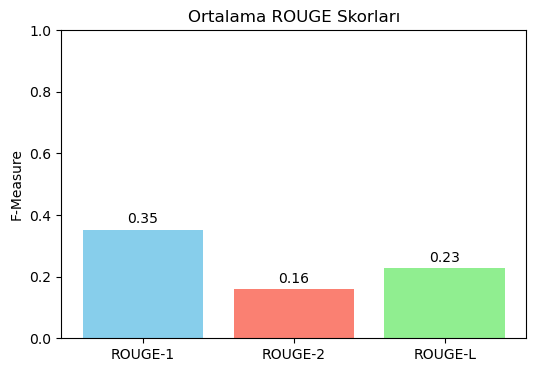

In [16]:
import matplotlib.pyplot as plt

metrics = ['ROUGE-1', 'ROUGE-2', 'ROUGE-L']
scores = [0.3531, 0.1607, 0.2294]

plt.figure(figsize=(6,4))
plt.bar(metrics, scores, color=['skyblue', 'salmon', 'lightgreen'])
plt.ylim(0,1)
plt.ylabel('F-Measure')
plt.title('Ortalama ROUGE Skorları')
for i, v in enumerate(scores):
    plt.text(i, v + 0.02, f"{v:.2f}", ha='center')
plt.show()


In [18]:
import pandas as pd
import numpy as np
from rouge_score import rouge_scorer

# Dosyayı oku
df = pd.read_excel(r"C:\\Users\\Tuğba\\Desktop\\tezYapim\\books3_özetli.xlsx")

reference_col = "Açıklama"
generated_col = "Özet"

scorer = rouge_scorer.RougeScorer(['rouge1','rouge2','rougeL'], use_stemmer=True)

# Boş listeler
rouge1_p, rouge1_r, rouge1_f = [], [], []
rouge2_p, rouge2_r, rouge2_f = [], [], []
rougel_p, rougel_r, rougel_f = [], [], []

vocab_overlap, coverage_ratio, unique_ref_words, unique_gen_words = [], [], [], []

for _, row in df.iterrows():
    ref = str(row[reference_col])
    gen = str(row[generated_col])

    if not ref.strip() or not gen.strip():
        rouge1_p.append(np.nan); rouge1_r.append(np.nan); rouge1_f.append(np.nan)
        rouge2_p.append(np.nan); rouge2_r.append(np.nan); rouge2_f.append(np.nan)
        rougel_p.append(np.nan); rougel_r.append(np.nan); rougel_f.append(np.nan)
        vocab_overlap.append(np.nan); coverage_ratio.append(np.nan)
        unique_ref_words.append(np.nan); unique_gen_words.append(np.nan)
        continue

    scores = scorer.score(ref, gen)

    # ROUGE-1
    rouge1_p.append(scores['rouge1'].precision)
    rouge1_r.append(scores['rouge1'].recall)
    rouge1_f.append(scores['rouge1'].fmeasure)
    # ROUGE-2
    rouge2_p.append(scores['rouge2'].precision)
    rouge2_r.append(scores['rouge2'].recall)
    rouge2_f.append(scores['rouge2'].fmeasure)
    # ROUGE-L
    rougel_p.append(scores['rougeL'].precision)
    rougel_r.append(scores['rougeL'].recall)
    rougel_f.append(scores['rougeL'].fmeasure)

    # Ek metrikler
    ref_words = set(ref.split())
    gen_words = set(gen.split())
    vocab_overlap.append(len(ref_words & gen_words) / len(ref_words | gen_words))
    coverage_ratio.append(len(ref_words & gen_words) / len(ref_words))
    unique_ref_words.append(len(ref_words))
    unique_gen_words.append(len(gen_words))

# DataFrame'e ekle
df['rouge1_precision'], df['rouge1_recall'], df['rouge1_f1'] = rouge1_p, rouge1_r, rouge1_f
df['rouge2_precision'], df['rouge2_recall'], df['rouge2_f1'] = rouge2_p, rouge2_r, rouge2_f
df['rougeL_precision'], df['rougeL_recall'], df['rougeL_f1'] = rougel_p, rougel_r, rougel_f
df['vocabulary_overlap'] = vocab_overlap
df['coverage_ratio'] = coverage_ratio
df['unique_ref_words'] = unique_ref_words
df['unique_gen_words'] = unique_gen_words

# Kaydet
df.to_excel(r"C:\\Users\\Tuğba\\Desktop\\tezYapim\\books3_rouge_detailed.xlsx", index=False)
print("✅ Her kitap için detaylı ROUGE skorları kaydedildi.")


✅ Her kitap için detaylı ROUGE skorları kaydedildi.


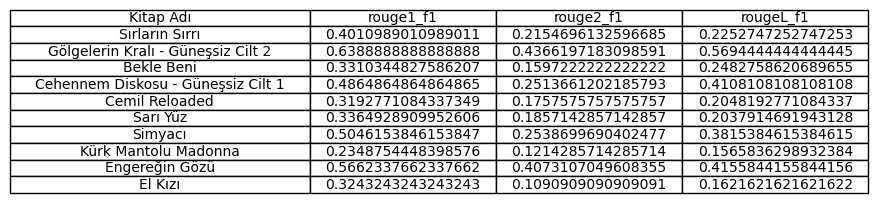

In [19]:
import matplotlib.pyplot as plt
import pandas as pd

# Excel'den tekrar oku
df = pd.read_excel(r"C:\\Users\\Tuğba\\Desktop\\tezYapim\\books3_rouge_detailed.xlsx")

# Örnek olarak ilk 10 kitabı al
sample_df = df.head(10)[['Kitap Adı', 'rouge1_f1', 'rouge2_f1', 'rougeL_f1']]

# Matplotlib ile tablo göster
fig, ax = plt.subplots(figsize=(10, 2))
ax.axis('off')
tbl = ax.table(cellText=sample_df.values,
               colLabels=sample_df.columns,
               cellLoc='center',
               loc='center')
tbl.auto_set_font_size(False)
tbl.set_fontsize(10)
tbl.auto_set_column_width([0,1,2,3])
plt.show()


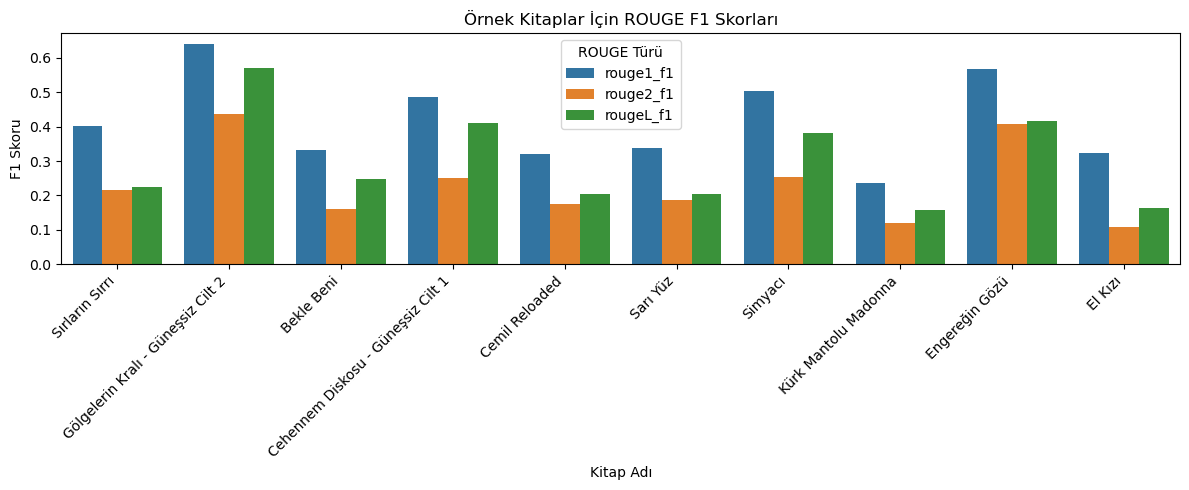

In [20]:
import seaborn as sns

# İlk 10 kitabın skorlarını al
plot_df = df.head(10)[['Kitap Adı', 'rouge1_f1', 'rouge2_f1', 'rougeL_f1']]
plot_df = plot_df.melt(id_vars='Kitap Adı', var_name='ROUGE Türü', value_name='F1 Skoru')

plt.figure(figsize=(12,5))
sns.barplot(data=plot_df, x='Kitap Adı', y='F1 Skoru', hue='ROUGE Türü')
plt.xticks(rotation=45, ha='right')
plt.title('Örnek Kitaplar İçin ROUGE F1 Skorları')
plt.tight_layout()
plt.show()


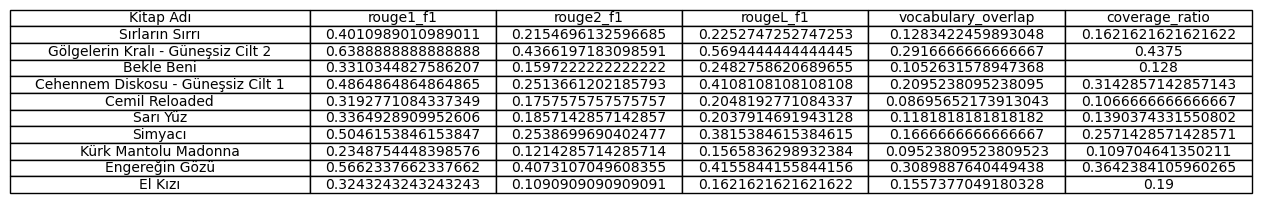

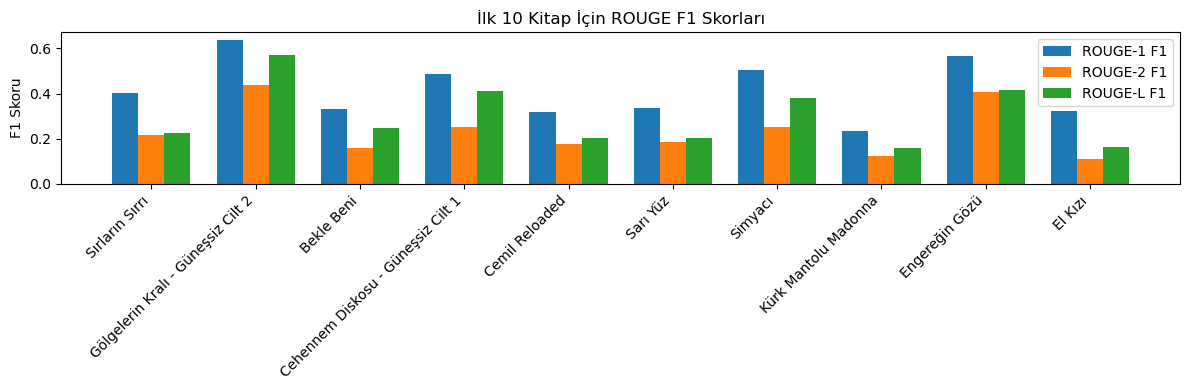

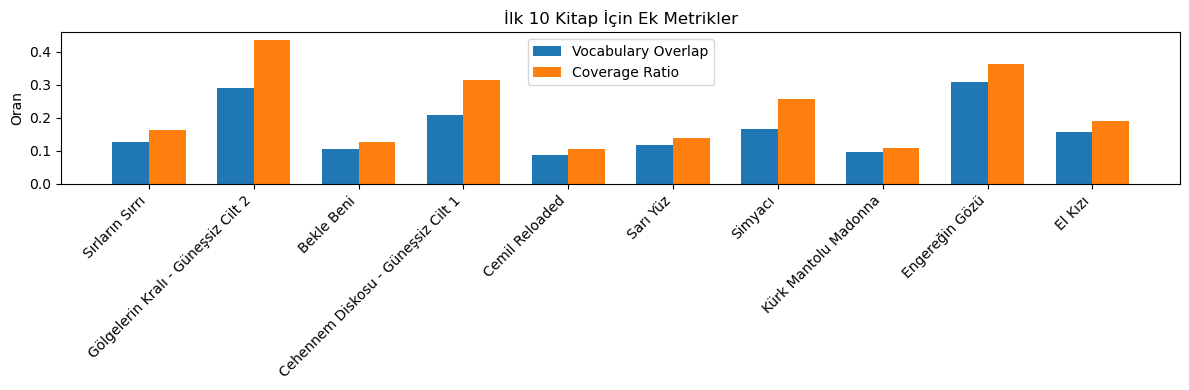

In [21]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

# Excel'den veri oku
df = pd.read_excel(r"C:\\Users\\Tuğba\\Desktop\\tezYapim\\books3_rouge_detailed.xlsx")

# İlk 10 kitabı al
sample_df = df.head(10)[['Kitap Adı', 'rouge1_f1', 'rouge2_f1', 'rougeL_f1',
                         'vocabulary_overlap', 'coverage_ratio']]

# -----------------------------
# 1. Tablo görselleştirme
# -----------------------------
fig, ax = plt.subplots(figsize=(12, 2))
ax.axis('off')
tbl = ax.table(cellText=sample_df.values,
               colLabels=sample_df.columns,
               cellLoc='center',
               loc='center')
tbl.auto_set_font_size(False)
tbl.set_fontsize(10)
tbl.auto_set_column_width([0,1,2,3,4,5])
plt.show()

# -----------------------------
# 2. ROUGE F1 Skorları Bar Chart
# -----------------------------
x = np.arange(len(sample_df['Kitap Adı']))  # kitap index
width = 0.25

fig, ax = plt.subplots(figsize=(12,4))
ax.bar(x - width, sample_df['rouge1_f1'], width, label='ROUGE-1 F1')
ax.bar(x, sample_df['rouge2_f1'], width, label='ROUGE-2 F1')
ax.bar(x + width, sample_df['rougeL_f1'], width, label='ROUGE-L F1')

ax.set_xticks(x)
ax.set_xticklabels(sample_df['Kitap Adı'], rotation=45, ha='right')
ax.set_ylabel('F1 Skoru')
ax.set_title('İlk 10 Kitap İçin ROUGE F1 Skorları')
ax.legend()
plt.tight_layout()
plt.show()

# -----------------------------
# 3. Ek Metrikler Bar Chart
# -----------------------------
fig, ax = plt.subplots(figsize=(12,4))
width = 0.35
ax.bar(x - width/2, sample_df['vocabulary_overlap'], width, label='Vocabulary Overlap')
ax.bar(x + width/2, sample_df['coverage_ratio'], width, label='Coverage Ratio')

ax.set_xticks(x)
ax.set_xticklabels(sample_df['Kitap Adı'], rotation=45, ha='right')
ax.set_ylabel('Oran')
ax.set_title('İlk 10 Kitap İçin Ek Metrikler')
ax.legend()
plt.tight_layout()
plt.show()
